<a href="https://colab.research.google.com/github/ReinerJasin/ai-app-sys/blob/main/Week11_12224827.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this week 11 session, we are going to learn about how to make a prediction on numerical data using Recurrent Neural Network using the libraries provided by torch

Let's begin by downloading the dataset about book store sales. Press the next link and open it in another window

> https://www.census.gov/econ/currentdata/



Select the highlighted data and press 'submit'

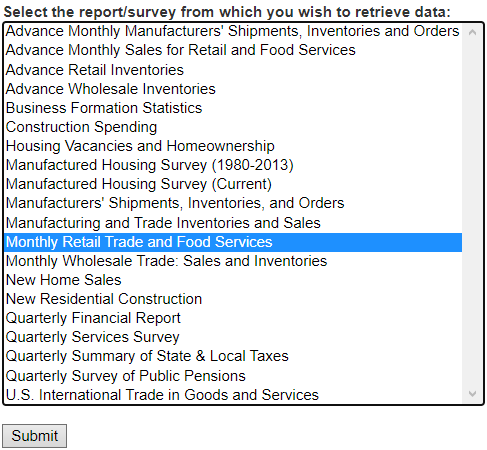

Once you're done, fill the form with these following informations

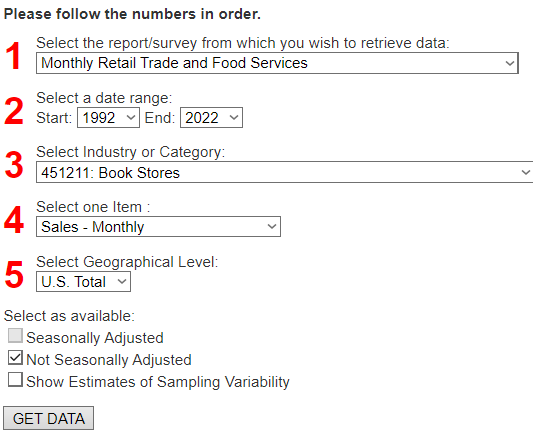

Scroll down until you see this section and then press the TXT link

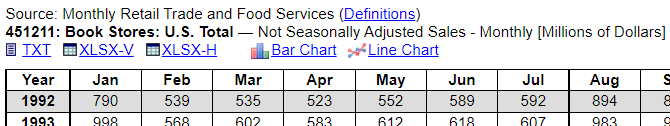

When you finish, your internet launcher will automatically download the data for you. But one thing we should notice is that we have to pre-process the data before finally able to use it.

Open the csv file and edit it until it looks like the following picture



> Beginning of the data



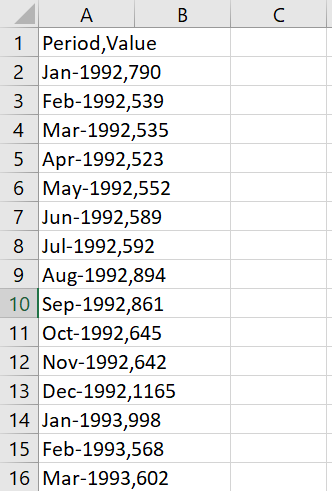



> The end of the data



Delete the data consists of non-numerical data like "NA" to prevent error in the training process

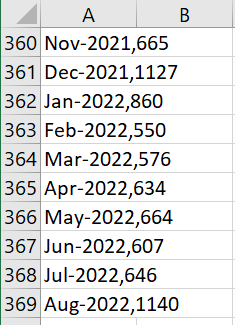

When the preprocessing step is finished, we can upload the dataset to google colab directory. The result will look like this

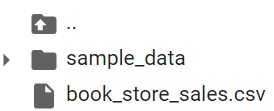

Now, let's import requests libraries to help us generate and process data to google colab working directory

In [1]:
import requests
# Save datagenerators as file to colab working directory
# If you are using GitHub, make sure you get the "Raw" version of the code
url = 'https://raw.githubusercontent.com/NVDLI/LDL/main/pt_framework/utilities.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import
with open('utilities.py', 'w') as f:
  f.write(r.text)

Continue the next step by importing the rest of the libraries, hyperparameters, and reading the file using the step below

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from utilities import train_model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
BATCH_SIZE = 16

TRAIN_TEST_SPLIT = 0.8
MIN = 12
FILE_NAME = '/content/book_store_sales.csv'

def readfile(file_name):
  file = open(file_name, 'r', encoding = 'utf-8')
  next(file)
  data = []
  for line in (file):
    values = line.split(',')
    data.append(float(values[1]))
  file.close()
  return np.array(data, dtype = np.float32)

# Read data and split up into train and test data.
sales = readfile(FILE_NAME)
months = len(sales)
split = int(months * TRAIN_TEST_SPLIT)
train_sales = sales[0:split]
test_sales = sales[split:]

After we read the data, let's show the result using matplotlib plots

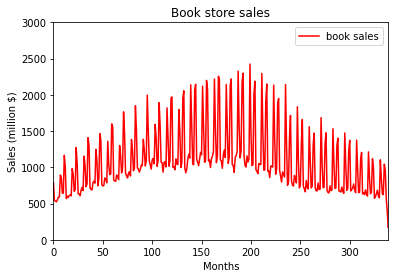

In [3]:
# Plot dataset
x = range(len(sales))
plt.plot(x, sales, 'r-', label = 'book sales')
plt.title('Book store sales')
plt.axis([0, 339, 0.0, 3000.0])
plt.xlabel('Months')
plt.ylabel('Sales (million $)')
plt.legend()
plt.show()

Now let's show another plot of the test output and naive prediction

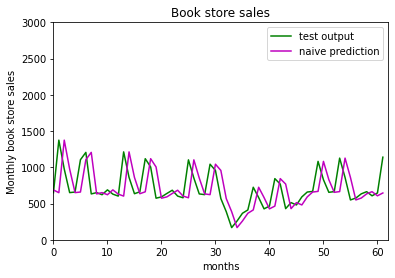

In [4]:
# Plot naive prediction
test_output = test_sales[MIN:]
naive_prediction = test_sales[MIN-1:-1]
x = range(len(test_output))
plt.plot(x, test_output, 'g-', label = 'test output')
plt.plot(x, naive_prediction, 'm-', label = 'naive prediction')
plt.title('Book store sales')
plt.axis([0, len(test_output), 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Monthly book store sales')
plt.legend()
plt.show()

Next, we are going to standardize the train and test data. Also we are going to count the standard deviation that will help us later on calculating the MSE and MAE. It will be explained again later in the next section.

In [5]:
# Standardize train and test data.
# Use only training seasons to compute mean and stddev.
mean = np.mean(train_sales)
stddev = np.std(train_sales)
train_sales_std = (train_sales - mean)/stddev
test_sales_std = (test_sales - mean)/stddev

After we standardize the dataset, we have to recreate all the train and test data to be used later on the RNN training step.

In [6]:
# Create train examples.
train_months = len(train_sales)
train_X = np.zeros((train_months-MIN, train_months-1, 1), dtype=np.float32)
train_y = np.zeros((train_months-MIN, 1), dtype=np.float32)
for i in range(0, train_months-MIN):
  train_X[i, -(i+MIN):, 0] = train_sales_std[0:i+MIN]
  train_y[i, 0] = train_sales_std[i+MIN]

# Create test examples.
test_months = len(test_sales)
test_X = np.zeros((test_months-MIN, test_months-1, 1), dtype=np.float32)
test_y = np.zeros((test_months-MIN, 1), dtype=np.float32)
for i in range(0, test_months-MIN):
  test_X[i, -(i+MIN):, 0] = test_sales_std[0:i+MIN]
  test_y[i, 0] = test_sales_std[i+MIN]

# Create Dataset objects.
trainset = TensorDataset(torch.from_numpy(train_X).clone(), torch.from_numpy(train_y))
testset = TensorDataset(torch.from_numpy(test_X).clone(), torch.from_numpy(test_y))

Now, we will start to build the RNN model by preparing the LastTimestep function to store the recurring value and the Sequential Model for the neural network. After that, we will train the model for 100 epochs to make a prediction later.

In [7]:
# Custom layer that retrieves only last time step from RNN output.
class LastTimestep(nn.Module):
  def forward(self, inputs):
    return inputs[1][0]

# Create RNN model
model = nn.Sequential(
    nn.RNN(1, 128, nonlinearity = 'relu', batch_first = True),
    LastTimestep(),
    nn.Linear(128, 1)
)

# Loss function and ooptimizer.
optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.MSELoss()

# Train model.
train_model(model, device, EPOCHS, BATCH_SIZE, trainset, testset, optimizer, loss_function, 'mae')

Epoch 1/100 loss: 0.9364 - mae: 0.7054 - val_loss: 0.9328 - val_mae: 0.8466
Epoch 2/100 loss: 0.7656 - mae: 0.6408 - val_loss: 0.3893 - val_mae: 0.5476
Epoch 3/100 loss: 0.5446 - mae: 0.5453 - val_loss: 0.2283 - val_mae: 0.3742
Epoch 4/100 loss: 0.5074 - mae: 0.4952 - val_loss: 0.4287 - val_mae: 0.5811
Epoch 5/100 loss: 0.4863 - mae: 0.5343 - val_loss: 0.3291 - val_mae: 0.4888
Epoch 6/100 loss: 0.4221 - mae: 0.4947 - val_loss: 0.2093 - val_mae: 0.3292
Epoch 7/100 loss: 0.5215 - mae: 0.5513 - val_loss: 0.2398 - val_mae: 0.3906
Epoch 8/100 loss: 0.5659 - mae: 0.5234 - val_loss: 0.3170 - val_mae: 0.5017
Epoch 9/100 loss: 0.4841 - mae: 0.5259 - val_loss: 0.1950 - val_mae: 0.3379
Epoch 10/100 loss: 0.4040 - mae: 0.4530 - val_loss: 0.1863 - val_mae: 0.3393
Epoch 11/100 loss: 0.3341 - mae: 0.4189 - val_loss: 0.1738 - val_mae: 0.3308
Epoch 12/100 loss: 0.2730 - mae: 0.3828 - val_loss: 0.1756 - val_mae: 0.3144
Epoch 13/100 loss: 0.2316 - mae: 0.3648 - val_loss: 0.1325 - val_mae: 0.2852
Epoch 14

[0.09182066698041227, 0.15935702994465828]

The training has been completed and we can output the result of the MSE and MAE

In [8]:
# Create naive prediction based on standardized data.
test_output = test_sales_std[MIN:]
naive_prediction = test_sales_std[MIN-1:-1]
mean_squared_error = np.mean(np.square(naive_prediction - test_output))
mean_abs_error = np.mean(np.abs(naive_prediction - test_output))
print('naive test mse: ', mean_squared_error)
print('naive test mean abs: ', mean_abs_error)

naive test mse:  0.37893176
naive test mean abs:  0.44875878




> Mean squared error (MSE) is the most commonly used loss function for regression. The loss is the mean overseen data of the squared differences between true and predicted values. <br><br>
source : https://peltarion.com/knowledge-center/modeling-view/build-an-ai-model/loss-functions/mean-squared-error




> Mean absolute error (MAE) is a loss function used for regression. The loss is the mean overseen data of the absolute differences between true and predicted values <br><br>
source : https://peltarion.com/knowledge-center/modeling-view/build-an-ai-model/loss-functions/mean-absolute-error



After we finished with the training process, we can predict all the test data and plot the result in a new figure to compare the prediction and real value

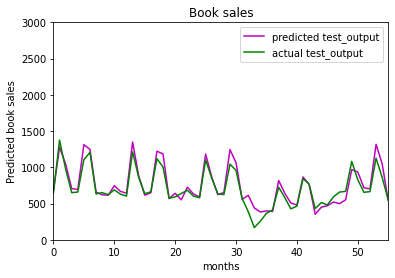

In [9]:
# Use trained model to predict the test data
inputs = torch.from_numpy(test_X)
inputs = inputs.to(device)
outputs = model(inputs)
predicted_test = outputs.cpu().detach().numpy()

# De-standardize output.
predicted_test = np.reshape(predicted_test, len(predicted_test))
predicted_test = predicted_test * stddev + mean

# Plot test prediction.
x = range(len(test_sales)-MIN)
plt.plot(x, predicted_test, 'm-', label = 'predicted test_output')
plt.plot(x, test_sales[-(len(test_sales)-MIN):], 'g-', label = 'actual test_output')
plt.title('Book sales')
plt.axis([0, 55, 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Predicted book sales')
plt.legend()
plt.show()

Our Recurrent Neural Network model has completed and is successful to make prediction with book sales value.